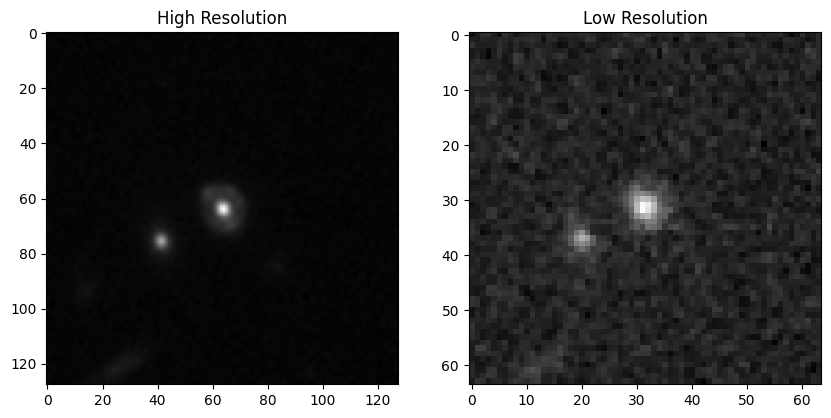

High Resolution Size:  (128, 128, 1)
Low Resolution Size:  (64, 64, 1)
High Resolution Range:  0.003715881 1.0158046
Low Resolution Range:  0.010345323 0.99508697


In [1]:
import os
import numpy as np




hr = "3b/HR/HR_3.npy"
lr = "3b/LR/LR_3.npy"

hr = np.load(hr)
lr = np.load(lr)
#reshaping
hr = np.transpose(hr, (1, 2, 0))
lr = np.transpose(lr, (1, 2, 0))

#plotting
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(hr , cmap='gray')
ax[0].set_title("High Resolution")
ax[1].imshow(lr , cmap='gray')
ax[1].set_title("Low Resolution")
plt.show()

#size
print("High Resolution Size: ", hr.shape)
print("Low Resolution Size: ", lr.shape)

#print range of pixel values
print("High Resolution Range: ", np.min(hr), np.max(hr))
print("Low Resolution Range: ", np.min(lr), np.max(lr))


In [2]:
import numpy as np
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, high_res_folder, low_res_folder, highres_transform, lowres_transform, both_transforms=None):
        self.high_res_folder = high_res_folder
        self.low_res_folder = low_res_folder
        self.highres_transform = highres_transform
        self.lowres_transform = lowres_transform
        self.both_transforms = both_transforms

        #get the file names for both high and low res images
        self.file_names = [f.split(".")[0] for f in os.listdir(high_res_folder)]

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        high_res_path = os.path.join(self.high_res_folder, f"HR_{self.file_names[idx].split('_')[-1]}.npy")
        low_res_path = os.path.join(self.low_res_folder, f"LR_{self.file_names[idx].split('_')[-1]}.npy")

        high_res_image = np.load(high_res_path)
        low_res_image = np.load(low_res_path)
        
        high_res_image = np.transpose(high_res_image, (1, 2, 0))
        low_res_image = np.transpose(low_res_image, (1, 2, 0))


        if self.highres_transform:
            high_res_image = self.highres_transform(high_res_image)

        if self.lowres_transform:
            low_res_image = self.lowres_transform(low_res_image)

        return low_res_image , high_res_image


#sizes
high_res_folder = "3b/HR"
low_res_folder = "3b/LR"

high_res_transform = transforms.Compose([
                                        #zero to 1 scaling
                                        transforms.ToTensor(),
                                        transforms.Normalize(0, 1),
])
                                        
low_res_transform = transforms.Compose([
                                        #zero to 1 scaling
                                        transforms.ToTensor(),
                                        transforms.Normalize(0, 1),])

                                        

dataset = CustomDataset(high_res_folder, low_res_folder, high_res_transform, low_res_transform)
print("Number of samples: ", len(dataset))
print("Sample 0: ", dataset[0][0].shape, dataset[0][1].shape)






Number of samples:  300
Sample 0:  torch.Size([1, 64, 64]) torch.Size([1, 128, 128])


In [9]:
import math
import torch
from torch import nn

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.bn1(residual)
        residual = self.prelu(residual)
        residual = self.conv2(residual)
        residual = self.bn2(residual)

        return x + residual


class UpsampleBLock(nn.Module):
    def __init__(self, in_channels, up_scale):
        super(UpsampleBLock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * up_scale ** 2, kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(up_scale)
        self.prelu = nn.PReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.prelu(x)
        return x
    



class Generator(nn.Module):
    def __init__(self, scale_factor):
        upsample_block_num = int(math.log(scale_factor, 2))

        super(Generator, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=9, padding=4),
            nn.PReLU()
        )
        self.block2 = ResidualBlock(64)
        self.block3 = ResidualBlock(64)
        self.block4 = ResidualBlock(64)
        self.block5 = ResidualBlock(64)
        self.block6 = ResidualBlock(64)
        self.block7 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
        )
        block8 = [UpsampleBLock(64, 2) for _ in range(upsample_block_num)]
        block8.append(nn.Conv2d(64, 1, kernel_size=9, padding=4))
        self.block8 = nn.Sequential(*block8)

    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)
        block6 = self.block6(block5)
        block7 = self.block7(block6)
        block8 = self.block8(block1 + block7)

        return (torch.tanh(block8) + 1) / 2


model = Generator(2)
print(model)
eg_input = torch.randn(1, 1, 32, 32)
print(model(eg_input).shape)


Generator(
  (block1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): PReLU(num_parameters=1)
  )
  (block2): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=1)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block3): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=1)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block4): ResidualBlock(
    (conv1)

In [4]:
import alive_progress
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import numpy as np

dataset = CustomDataset(high_res_folder, low_res_folder, high_res_transform, low_res_transform)
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
 
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size] , generator=torch.Generator().manual_seed(176))

data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

save_path = "model_3b/"

epochs = 10000

def calculate_ssim(img1, img2):
    return ssim(img1, img2, data_range=1)

def calculate_psnr(img1, img2):
    return psnr(img1, img2, data_range=1)

def calculate_mmse(img1, img2):
    return np.mean((img1 - img2) ** 2)

#AdamW witn reduce on plateau
optimizer = torch.optim.Adam(model.parameters(), lr=0.00003)
#optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001)
#
#cosine annealing learning rate
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.000001 )
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True  )
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#criterion = nn.MSELoss()
criterion = nn.L1Loss()
best_mse = 1.0
best_ssim = 0.0
best_psnr = 0.0


for epoch in range(epochs):
    model.train()
    for lr, hr in data_loader:
        lr = lr.to(device)
        hr = hr.to(device)
        model.to(device)


        optimizer.zero_grad()
        sr = model(lr)
        loss = criterion(sr, hr)
        loss.backward()
        optimizer.step()
        #scheduler.step()
        #cheduler.step(loss)

    model = model.eval()
    ssim_scores = []
    psnr_scores = []
    mmse_scores = []
    
    for lr, hr in test_loader:
        with torch.no_grad():
            model.to("cuda")
            sr = model(lr.to("cuda"))
            sr = sr.squeeze(1).to("cpu").detach().numpy()
            hr = hr.squeeze(1).numpy()
            
            for i in range(sr.shape[0]):
                ssim_scores.append(calculate_ssim(sr[i], hr[i]))
                psnr_scores.append(calculate_psnr(sr[i], hr[i]))
                mmse_scores.append(calculate_mmse(sr[i], hr[i]))
    if epoch % 20 == 0:
        print("Average SSIM: ", np.mean(ssim_scores))
        print("Average PSNR: ", np.mean(psnr_scores))
        print("Average MMSE: ", np.mean(mmse_scores))

    if np.mean(ssim_scores) > best_ssim:
        best_ssim = np.mean(ssim_scores)
        torch.save(model.state_dict(), save_path + f"3b_SRGAN_GenOnly_Val_data.pth")


    





/home/arnesh/.local/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Average SSIM:  0.5154523889854208
Average PSNR:  21.134913753568313
Average MMSE:  0.0092406785
Average SSIM:  0.8772059604230039
Average PSNR:  35.322035760388864
Average MMSE:  0.00041171044
Average SSIM:  0.8684274588838644
Average PSNR:  34.96663937769504
Average MMSE:  0.0004965977
Average SSIM:  0.8859338537108087
Average PSNR:  35.88491457941795
Average MMSE:  0.0004301016
Average SSIM:  0.8212970206807583
Average PSNR:  34.726952409285595
Average MMSE:  0.0005183567
Average SSIM:  0.8865308536458296
Average PSNR:  36.54323518785892
Average MMSE:  0.00038224686
Average SSIM:  0.9019398697178657
Average PSNR:  36.95005865505735
Average MMSE:  0.00035969767


KeyboardInterrupt: 

In [10]:
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
 
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size] , generator=torch.Generator().manual_seed(176))


test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

In [11]:
#SSIM, PSNR, MMSE on test data
model = Generator(2)
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
pretrained_path = "model_3b/3b_SRGAN_GenOnly_Val_data.pth"
model.load_state_dict(torch.load(pretrained_path))

def calculate_ssim(img1, img2):
    return ssim(img1, img2, data_range= img2.max() - img2.min())

def calculate_psnr(img1, img2):
    return psnr(img1, img2)

def calculate_mmse(img1, img2):
    return np.mean((img1 - img2) ** 2)

model = model.eval()
ssim_scores = []
psnr_scores = []
mmse_scores = []
for lr, hr in test_loader:
    with torch.no_grad():
        model.to("cuda")
        sr = model(lr.to("cuda"))
        sr = sr.squeeze(1).to("cpu").detach().numpy()
        hr = hr.squeeze(1).numpy()
        
        for i in range(sr.shape[0]):
            ssim_scores.append(calculate_ssim(sr[i], hr[i]))
            psnr_scores.append(calculate_psnr(sr[i], hr[i]))
            mmse_scores.append(calculate_mmse(sr[i], hr[i]))

print("Average SSIM: ", np.mean(ssim_scores))
print("Average PSNR: ", np.mean(psnr_scores))
print("Average MMSE: ", np.mean(mmse_scores))
    

Average SSIM:  0.9022176119761735
Average PSNR:  36.950043841899884
Average MMSE:  0.0003597185


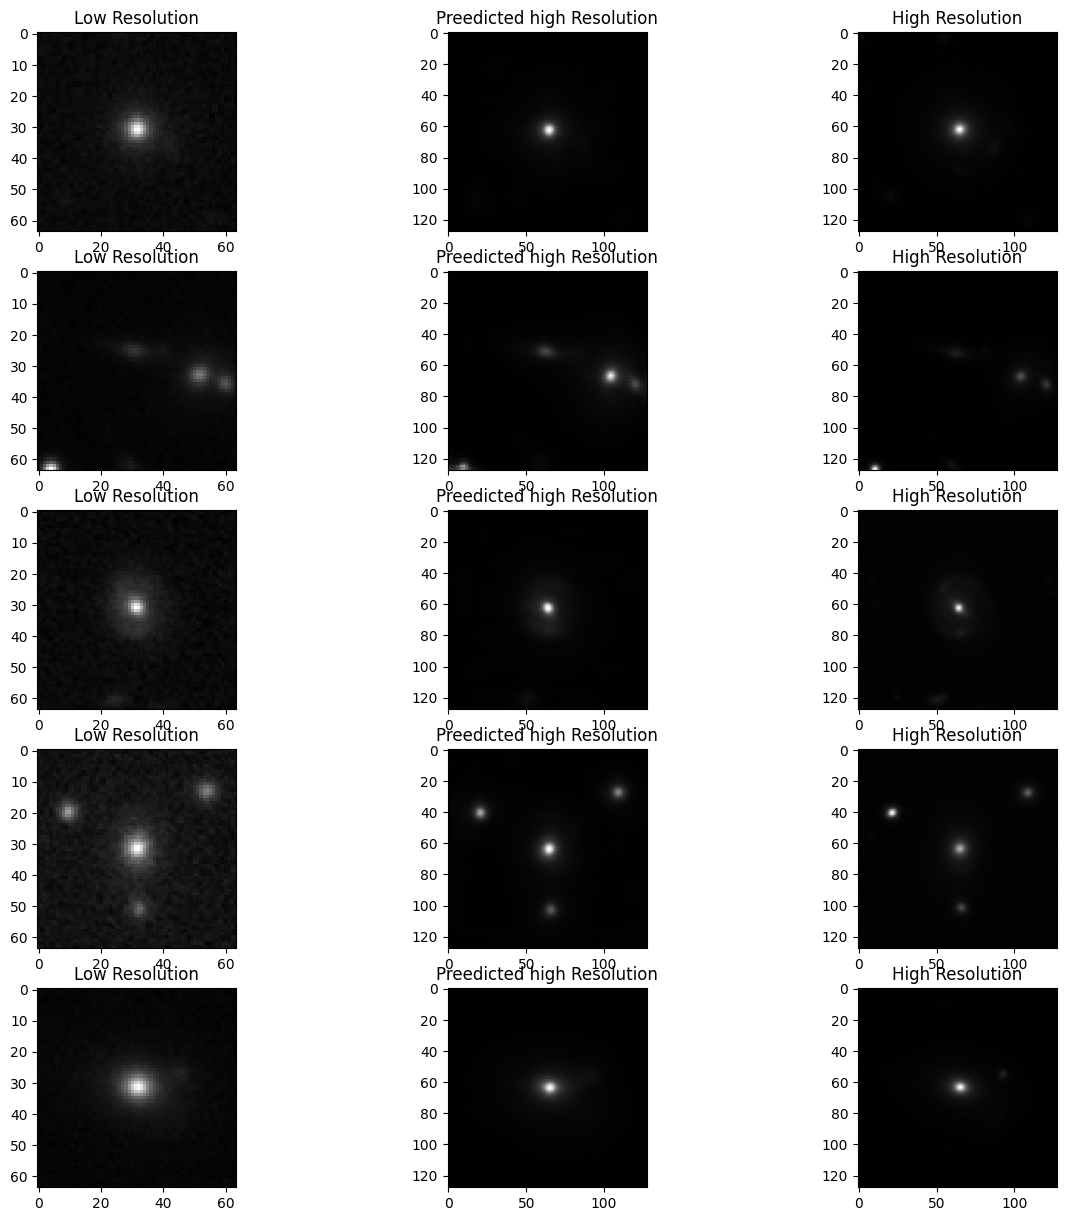

In [21]:
#plot first 5 images
import matplotlib.pyplot as plt
model = model.eval()
fig, ax = plt.subplots(5, 3, figsize=(15, 15))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

for i, (lr, hr) in enumerate(test_loader):
    if i == 5:
        break
    with torch.no_grad():
        model.to("cuda")
        sr = model(lr.to("cuda"))
        sr = sr.squeeze(1).to("cpu").detach().numpy()
        hr = hr.squeeze(1).numpy()
        ax[i, 0].imshow(lr.squeeze(1).numpy().squeeze(), cmap='gray')
        ax[i, 0].set_title("Low Resolution")
        ax[i, 1].imshow(sr.squeeze(), cmap='gray')
        ax[i, 1].set_title("Preedicted high Resolution")
        ax[i, 2].imshow(hr.squeeze(), cmap='gray')
        ax[i, 2].set_title("High Resolution")